---
title: "추천 시스템 스터디 실습 예제 3"
author: "Sangkon Han"
---

## 넷플릭스 경진대회(Netflix Prize)
- 2006년부터 3년간 운영된 경진 대회
- 추천 시스템 품질을 10% 개선하는 팀에서 $1M 수여
    - RMSE가 평가 기준
    - 사용자와 영화 페어 평점을 예측하고 정답값과 비교
- 브랜드 인지도 / 프라이버시


# 인기 영화 추천 시스템을 만들어 보자

- 이 [데이터셋](https://www.kaggle.com/tmdb/tmdb-movie-metadata)은 영화에 대한 정보(예산, 장르, 평점, 런닝시간, 제목, 키워드 등등)와 영화 연출팀과 배우들에 대한 별도 정보로 구성되어 있으며 일반 사용자들이 이 정보를 입력하여 구성
- 이를 바탕으로 인기 영화 추천을 간단하게 작성
    - 넷플릭스를 보면 "넷플릭스 인기 콘텐츠"라는 추천 카테고리가 있는데 같은 거라 보면 된다
- 장르를 기준으로 그 안에서 인기영화를 추천

## 입력 데이터 로딩

- 영화 정보는 `tmdb_5000_movies.csv`
- 연출/배우에 대한 정보는 `tmdb_5000_credits.csv`

이 두 파일은 영화의 id 필드와 연출/배우의 movie_id 필드로 조인 가능하다.

In [ ]:
import pandas as pd
import numpy as np

: 

In [ ]:
movies = pd.read_csv("https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/tmdb_5000_movies.csv")

In [ ]:
credits = pd.read_csv("https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/tmdb_5000_credits.csv")

In [ ]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [ ]:
movies.shape

(4803, 20)

In [ ]:
import json

def add_genre_name(j):
    genres = []
    ar = json.loads(j)
    for a in ar:
        genres.append(a.get("name"))
    return " ".join(sorted(genres))

movies['genres_name'] = movies.apply(lambda x: add_genre_name(x.genres), axis=1)

In [ ]:
movies[['genres_name']].head()   # vs. movies['genres_name'].head()

,genres_name
0,Action Adventure Fantasy Science Fiction
1,Action Adventure Fantasy
2,Action Adventure Crime
3,Action Crime Drama Thriller
4,Action Adventure Science Fiction


In [ ]:
movies['genres_name'].nunique()

638

In [ ]:
movies.groupby('genres_name').size()

genres_name
                                            28
Action                                      21
Action Adventure                            15
Action Adventure Animation                   1
Action Adventure Animation Comedy Family     5
                                            ..
Science Fiction Thriller                    12
Thriller                                    23
War                                          2
War Western                                  1
Western                                     18
Length: 638, dtype: int64

In [ ]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [ ]:
credits.shape

(4803, 4)

### movies와 credits 데이터프레임을 조인

In [ ]:
movie_credits = pd.merge(movies, credits, left_on='id', right_on='movie_id')

In [ ]:
movie_credits.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,status,tagline,title_x,vote_average,vote_count,genres_name,movie_id,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,Released,Enter the World of Pandora.,Avatar,7.2,11800,Action Adventure Fantasy Science Fiction,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Action Adventure Fantasy,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,Released,A Plan No One Escapes,Spectre,6.3,4466,Action Adventure Crime,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Action Crime Drama Thriller,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,Released,"Lost in our world, found in another.",John Carter,6.1,2124,Action Adventure Science Fiction,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [ ]:
movie_credits = movie_credits.drop(columns=['homepage', 'title_x', 'title_y', 'status','production_countries', 'production_companies'])
movie_credits.head()

,budget,genres,id,keywords,original_language,original_title,overview,popularity,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,genres_name,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Enter the World of Pandora.,7.2,11800,Action Adventure Fantasy Science Fiction,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","At the end of the world, the adventure begins.",6.9,4500,Action Adventure Fantasy,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",A Plan No One Escapes,6.3,4466,Action Adventure Crime,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Legend Ends,7.6,9106,Action Crime Drama Thriller,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","Lost in our world, found in another.",6.1,2124,Action Adventure Science Fiction,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [ ]:
movie_credits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   budget             4803 non-null   int64  
 1   genres             4803 non-null   object 
 2   id                 4803 non-null   int64  
 3   keywords           4803 non-null   object 
 4   original_language  4803 non-null   object 
 5   original_title     4803 non-null   object 
 6   overview           4800 non-null   object 
 7   popularity         4803 non-null   float64
 8   release_date       4802 non-null   object 
 9   revenue            4803 non-null   int64  
 10  runtime            4801 non-null   float64
 11  spoken_languages   4803 non-null   object 
 12  tagline            3959 non-null   object 
 13  vote_average       4803 non-null   float64
 14  vote_count         4803 non-null   int64  
 15  genres_name        4803 non-null   object 
 16  movie_id           4803 

In [ ]:
movie_credits.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,movie_id
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989,57165.484281
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891,88694.614033
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000,9014.500000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000,14629.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000,58610.500000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,459488.000000


In [ ]:
popularity = movie_credits.sort_values('popularity',ascending=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

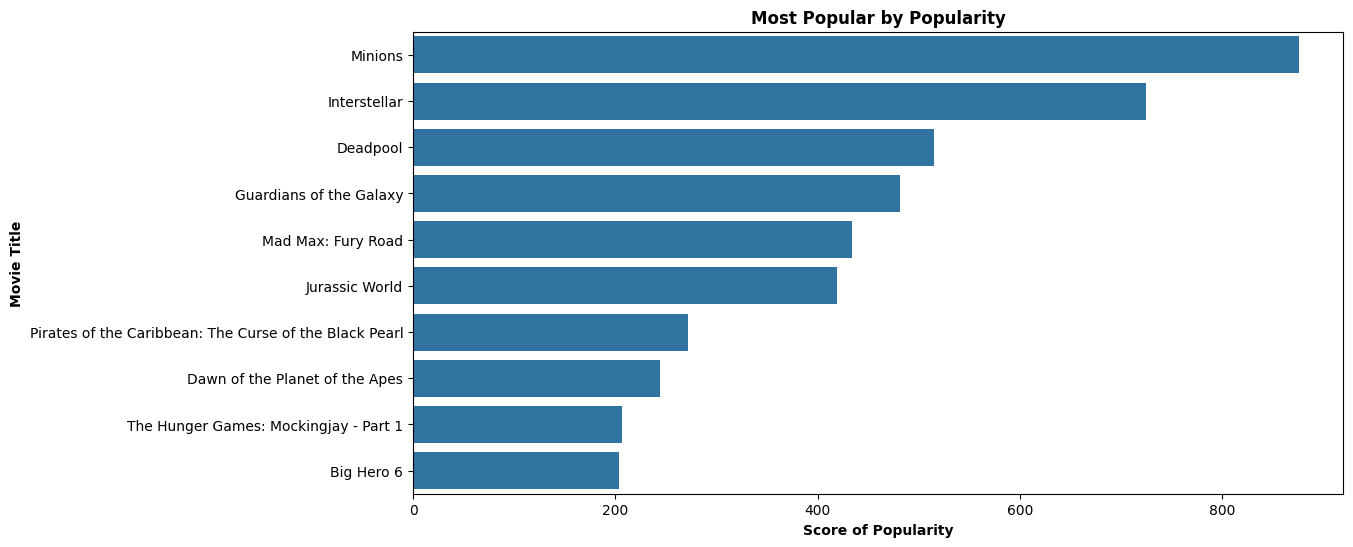

In [ ]:
plt.figure(figsize=(12,6))
ax=sns.barplot(
    x=popularity['popularity'].head(10),
    y=popularity['original_title'].head(10)
)

plt.title('Most Popular by Popularity', weight='bold')
plt.xlabel('Score of Popularity', weight='bold')
plt.ylabel('Movie Title', weight='bold')
plt.savefig('best_popular_movies.png')

In [ ]:
def reco_top_scored_one(n, genre=None):
  if genre is None:
    return popularity["original_title"].head(n)
  else:
    return popularity[popularity['genres_name'].str.contains(genre)]["original_title"].head(n)

In [ ]:
print(reco_top_scored_one(10))

546                                              Minions
95                                          Interstellar
788                                             Deadpool
94                               Guardians of the Galaxy
127                                   Mad Max: Fury Road
28                                        Jurassic World
199    Pirates of the Caribbean: The Curse of the Bla...
82                        Dawn of the Planet of the Apes
200                The Hunger Games: Mockingjay - Part 1
88                                            Big Hero 6
Name: original_title, dtype: object


In [ ]:
print(reco_top_scored_one(10, "Science Fiction"))

95                              Interstellar
94                   Guardians of the Galaxy
127                       Mad Max: Fury Road
28                            Jurassic World
82            Dawn of the Planet of the Apes
200    The Hunger Games: Mockingjay - Part 1
108                       Terminator Genisys
26                Captain America: Civil War
270                              The Martian
96                                 Inception
Name: original_title, dtype: object


In [ ]:
print(reco_top_scored_one(10, "Action"))

788                                             Deadpool
94                               Guardians of the Galaxy
127                                   Mad Max: Fury Road
28                                        Jurassic World
199    Pirates of the Caribbean: The Curse of the Bla...
82                        Dawn of the Planet of the Apes
88                                            Big Hero 6
108                                   Terminator Genisys
26                            Captain America: Civil War
65                                       The Dark Knight
Name: original_title, dtype: object
